In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os
from pytorch_adapt.layers import MMDLoss
from copy import deepcopy
from itertools import cycle
import torch.nn.functional as F
import random
from sklearn.manifold import TSNE

In [6]:
domains = ["Art", "Clip Art", "Real World"]

NUM_CLASSES = 65
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [7]:
d_t = "Art"
d_s = "Real World"

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [8]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

source_folder = os.path.join("officehome", d_s)
target_folder = os.path.join("officehome", d_t)

train_dataset = torchvision.datasets.ImageFolder(source_folder, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(target_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

len(train_loader), len(test_loader)


(137, 76)

In [12]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

def infinite_loader(loader):
    while True:
        for batch in loader:
            yield batch

def train_loop(source, target, model, loss_fn, optimizer, device):
    model.to(device)
    model.train()
    losses = []
    accuracies = []

    hook_2 = model.layer2.register_forward_hook(get_features('layer2'))
    hook_3 = model.layer3.register_forward_hook(get_features('layer3'))
    hook_4 = model.layer4.register_forward_hook(get_features('layer4'))
    mmd_loss = MMDLoss().to("cpu")
    target = infinite_loader(target)
    for (x_s, y_s) in tqdm(source):
        x_t, _ = next(target)
        x_s, y_s = x_s.to(device), y_s.to(device)
        size = min(x_s.size(0), x_t.size(0))
        x_s, y_s = x_s[:size], y_s[:size]
        x_t = x_t[:size].to(device)

        pred = model(x_s)
        source_features = [features['layer2'], features['layer3'], features['layer4']]
        accuracy = (pred.argmax(1) == y_s).float().mean().item()

        _ = model(x_t)
        target_features = [features['layer2'], features['layer3'], features['layer4']]

        loss = loss_fn(pred, y_s)
        
        source_features = [F.adaptive_avg_pool2d(f, (1,1)).view(f.size(0), -1) for f in source_features]
        target_features = [F.adaptive_avg_pool2d(f, (1,1)).view(f.size(0), -1) for f in target_features]

        for sf, tf in zip(source_features, target_features):
            sf,tf = sf.to("cpu"), tf.to("cpu")
            loss += mmd_loss(sf, tf)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracies.append(accuracy)
        losses.append(loss.item())

    hook_2.remove()
    hook_3.remove()
    hook_4.remove()

    return np.mean(losses), np.mean(accuracies)

def evaluate(dataloader, model, loss_fn, device):
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            accuracies.append((pred.argmax(1) == y).float().mean().item())
    return np.mean(losses), np.mean(accuracies)

# DAN (Deep Alignment Network)

In [13]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
model = model.to(device)

In [14]:
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for i in range(NUM_EPOCHS):
    train_loss, train_acc = train_loop(train_loader, test_loader, model, loss_fn, optimizer, device)
    test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
    print(f"Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

100%|██████████| 76/76 [00:24<00:00,  3.12it/s]


Epoch 1/10, Train Loss: 4.0273, Train Acc: 0.0665, Test Loss: 5.3455, Test Acc: 0.0507


100%|██████████| 76/76 [00:23<00:00,  3.30it/s]


Epoch 2/10, Train Loss: 3.6114, Train Acc: 0.1136, Test Loss: 4.1737, Test Acc: 0.0593


100%|██████████| 76/76 [00:27<00:00,  2.74it/s]


Epoch 3/10, Train Loss: 3.4146, Train Acc: 0.1388, Test Loss: 4.2188, Test Acc: 0.0636


100%|██████████| 76/76 [00:25<00:00,  2.98it/s]


Epoch 4/10, Train Loss: 3.0979, Train Acc: 0.2016, Test Loss: 4.0893, Test Acc: 0.0982


100%|██████████| 76/76 [00:25<00:00,  2.99it/s]


Epoch 5/10, Train Loss: 2.8816, Train Acc: 0.2456, Test Loss: 4.4067, Test Acc: 0.1210


100%|██████████| 76/76 [00:25<00:00,  2.97it/s]


Epoch 6/10, Train Loss: 2.7260, Train Acc: 0.2730, Test Loss: 4.1748, Test Acc: 0.1252


100%|██████████| 76/76 [00:26<00:00,  2.92it/s]


Epoch 7/10, Train Loss: 2.3975, Train Acc: 0.3462, Test Loss: 3.9467, Test Acc: 0.1438


100%|██████████| 76/76 [00:25<00:00,  2.93it/s]


Epoch 8/10, Train Loss: 2.1462, Train Acc: 0.4007, Test Loss: 4.3205, Test Acc: 0.1505


100%|██████████| 76/76 [00:25<00:00,  2.95it/s]


Epoch 9/10, Train Loss: 1.9034, Train Acc: 0.4516, Test Loss: 4.2654, Test Acc: 0.1343


100%|██████████| 76/76 [00:26<00:00,  2.90it/s]

Epoch 10/10, Train Loss: 2.1366, Train Acc: 0.4103, Test Loss: 4.1244, Test Acc: 0.1838


In [15]:
torch.save(model.state_dict(), f"resnet50_dan.pth")

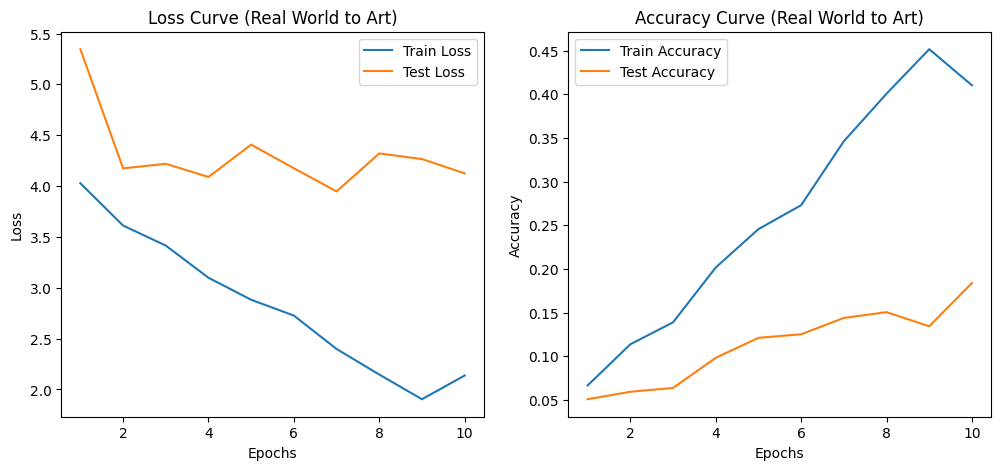

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curve ({d_s} to {d_t})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve ({d_s} to {d_t})')
plt.legend()
plt.show()

# Concept Shift

In [19]:
def simulate_concept_shift(source_dataset, target_dataset, rare_fraction=0.2, removed_classes=5):
    np.random.seed(42)
    random.seed(42)

    # Unique class indices
    classes = list(range(len(source_dataset.classes)))

    # Pick random classes to remove from target (simulate label shift)
    removed = random.sample(classes, removed_classes)
    print(f"Removed classes from target: {removed}")

    # Rare class (under-represented)
    rare_class = random.choice([c for c in classes if c not in removed])
    print(f"Rare class in target: {rare_class}")

    # --- Filter target indices ---
    target_indices = []
    for i, (_, label) in enumerate(target_dataset):
        if label not in removed:
            if label == rare_class:
                # Keep only a small fraction of rare class
                if np.random.rand() < rare_fraction:
                    target_indices.append(i)
            else:
                target_indices.append(i)

    shifted_target = torch.utils.data.Subset(target_dataset, target_indices)
    return shifted_target


In [22]:
shifted_target_dataset = simulate_concept_shift(train_dataset, test_dataset, rare_fraction=0.2, removed_classes=5)
shifted_target_loader = torch.utils.data.DataLoader(shifted_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

Removed classes from target: [14, 3, 35, 31, 28]
Rare class in target: 9


In [23]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
model = model.to(device)

In [24]:
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for i in range(NUM_EPOCHS):
    train_loss, train_acc = train_loop(train_loader, shifted_target_loader, model, loss_fn, optimizer, device)
    test_loss, test_acc = evaluate(shifted_target_loader, model, loss_fn, device)
    print(f"Concept Shift - Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

100%|██████████| 68/68 [00:20<00:00,  3.26it/s]


Concept Shift - Epoch 1/10, Train Loss: 4.2229, Train Acc: 0.0372, Test Loss: 4.3235, Test Acc: 0.0234


100%|██████████| 68/68 [00:20<00:00,  3.29it/s]


Concept Shift - Epoch 2/10, Train Loss: 4.0327, Train Acc: 0.0471, Test Loss: 4.2897, Test Acc: 0.0368


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Concept Shift - Epoch 3/10, Train Loss: 3.9303, Train Acc: 0.0693, Test Loss: 4.3103, Test Acc: 0.0496


100%|██████████| 68/68 [00:21<00:00,  3.22it/s]


Concept Shift - Epoch 4/10, Train Loss: 3.8851, Train Acc: 0.0727, Test Loss: 4.2021, Test Acc: 0.0372


100%|██████████| 68/68 [00:21<00:00,  3.23it/s]


Concept Shift - Epoch 5/10, Train Loss: 3.7457, Train Acc: 0.0894, Test Loss: 4.2625, Test Acc: 0.0494


100%|██████████| 68/68 [00:20<00:00,  3.30it/s]


Concept Shift - Epoch 6/10, Train Loss: 3.6223, Train Acc: 0.0977, Test Loss: 4.1980, Test Acc: 0.0577


100%|██████████| 68/68 [00:20<00:00,  3.27it/s]


Concept Shift - Epoch 7/10, Train Loss: 3.6062, Train Acc: 0.1223, Test Loss: 4.2747, Test Acc: 0.0538


100%|██████████| 68/68 [00:20<00:00,  3.26it/s]


Concept Shift - Epoch 8/10, Train Loss: 3.4101, Train Acc: 0.1446, Test Loss: 4.7477, Test Acc: 0.0468


100%|██████████| 68/68 [00:20<00:00,  3.29it/s]


Concept Shift - Epoch 9/10, Train Loss: 3.3529, Train Acc: 0.1660, Test Loss: 4.3693, Test Acc: 0.0705


100%|██████████| 68/68 [00:20<00:00,  3.28it/s]

Concept Shift - Epoch 10/10, Train Loss: 3.2239, Train Acc: 0.1888, Test Loss: 4.3324, Test Acc: 0.0698


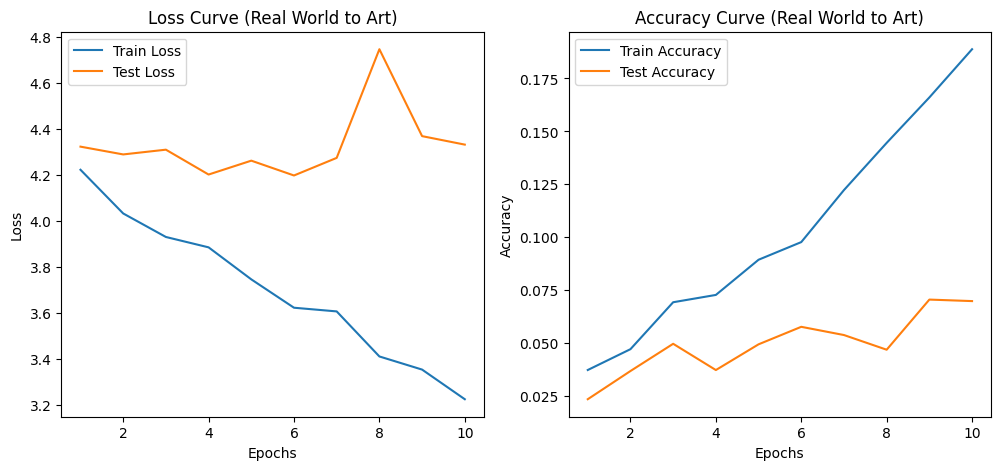

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curve ({d_s} to {d_t})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve ({d_s} to {d_t})')
plt.legend()
plt.show()

# Visualisation

In [9]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(f"resnet50_dan.pth"))

<All keys matched successfully>

In [10]:
features_map = []
labels = []

def get_feature():
    def hook(model, input, output):
        features_map.append(output.detach().cpu())
    return hook

# Register hook
model_hook = model.avgpool.register_forward_hook(get_feature())

model.to(device)
model.eval()

def extract_features(loader, max_samples=1000):
    features_map.clear()
    labels.clear()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _ = model(x)
            labels.extend(y.cpu().numpy())

            if len(labels) >= max_samples:
                break

    features = torch.cat(features_map, dim=0).view(len(labels), -1)[:max_samples]
    return features, labels[:max_samples]

# --- Extract features for train and test ---
train_features, train_labels = extract_features(train_loader, max_samples=1000)
test_features, test_labels = extract_features(test_loader, max_samples=1000)

# Remove hook after done
model_hook.remove()

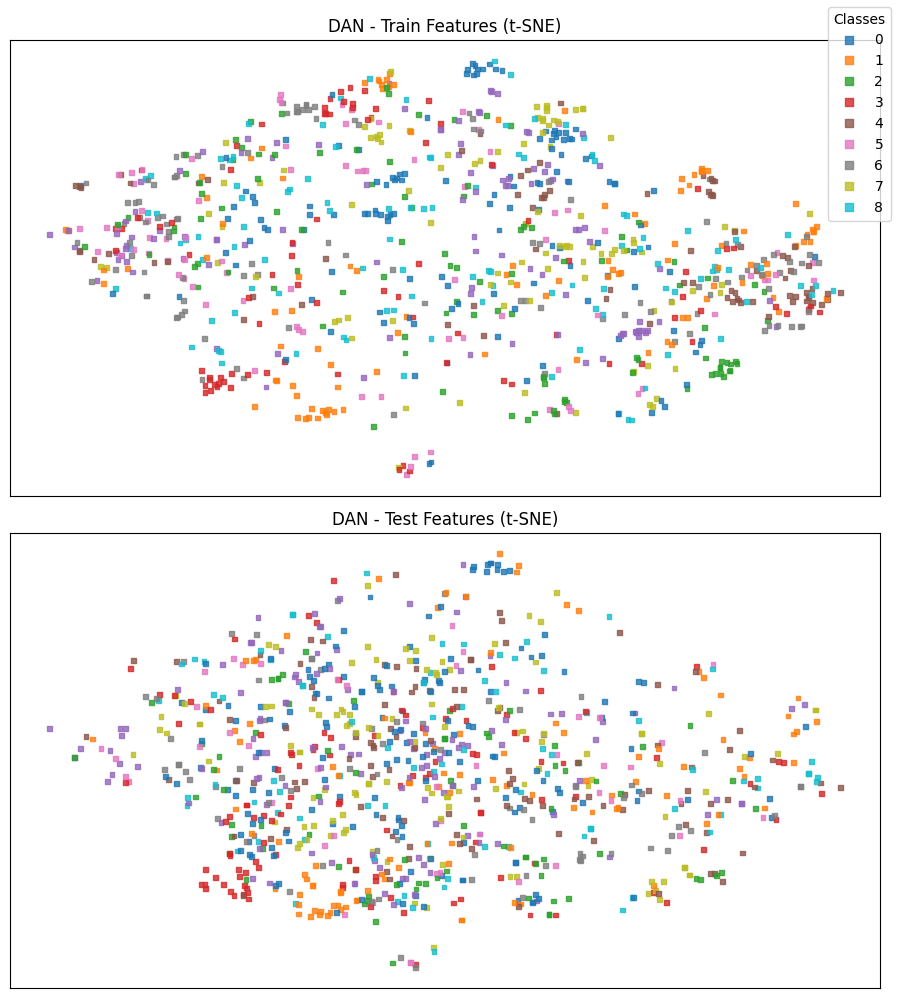

In [16]:
def plot_tsne(train_features, train_labels, test_features, test_labels, perplexity=30, random_state=42):
    # Convert tensors to numpy
    train_features = train_features.cpu().numpy() if hasattr(train_features, "cpu") else np.array(train_features)
    test_features = test_features.cpu().numpy() if hasattr(test_features, "cpu") else np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Joint t-SNE for consistent space
    combined_features = np.concatenate([train_features, test_features], axis=0)
    combined_2d = TSNE(n_components=2, perplexity=perplexity, random_state=random_state).fit_transform(combined_features)

    n_train = len(train_features)
    train_2d, test_2d = combined_2d[:n_train], combined_2d[n_train:]

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(2,1, figsize=(9, 10))

    scatter_train = axes[0].scatter(train_2d[:, 0], train_2d[:, 1],
                                    c=train_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[0].set_title("DAN - Train Features (t-SNE)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    scatter_test = axes[1].scatter(test_2d[:, 0], test_2d[:, 1],
                                   c=test_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[1].set_title("DAN - Test Features (t-SNE)")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Shared legend for class colors
    handles, _ = scatter_train.legend_elements(prop="colors")
    fig.legend(handles, np.unique(train_labels), title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()

plot_tsne(train_features, train_labels, test_features, test_labels)